- 굳이 공부하진 말고 읽고 넘어가라.
- 공부하고 싶다면 Reduce정도..?

In [1]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster('local').setAppName('reduction-op')
sc = SparkContext(conf = conf)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/05 02:03:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Reduce
- 사용자가 지정하는 함수를 받아(task) 여러 개의 값을 하나로 줄여준다.
- 파티션 별로 작업이 일어난다.

In [2]:
from operator import add

In [3]:
add(1,2)

3

In [4]:
sample_rdd = sc.parallelize([1,2,3,4,5])  # RDD
sample_rdd

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:274

In [5]:
sample_rdd.reduce(add)

15

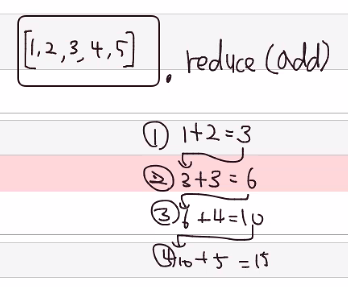

In [6]:
# 파티션이 1개인 경우(입력하지 않으면 기본=1)
sample_rdd1 = sc.parallelize([1,2,3,4],1)
sample_rdd1.reduce(lambda x, y : (x*2)+y)

# 파티션이 1개
sample_rdd1.glom().collect()

[[1, 2, 3, 4]]

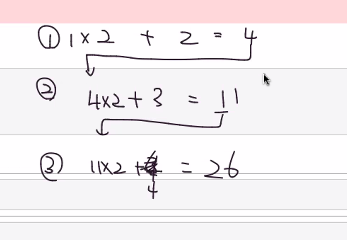

In [7]:
# glom: 파티션 별 데이터를 보여주고 싶을 때 사용
sample_rdd_p2 = sc.parallelize([1,2,3,4],2)
sample_rdd_p2.glom().collect()

[[1, 2], [3, 4]]

In [8]:
sample_rdd_p2.reduce(lambda x,y: (x*2)+y)

18

- task1 = (1*2) +2 =4
- task2 = (3*2) +4 =10
- task3 = (4*2) +10 = 18
---

In [9]:
sample_rdd_p3 = sc.parallelize([1,2,3,4],3)
sample_rdd_p3.reduce(lambda x, y:(x * 2) + y)

18

In [10]:
sample_rdd_p3.glom().collect()

[[1], [2], [3, 4]]

우리가 수행하는 task는 변수가 x,y 두개여야하는데 partition1, 2는 변수 1개.
따라서 그 숫자 그대로 나옴

task1 = 1
task2 = 2
task3 = 3*2+4 =10

task1,2 => 1*2 +2 = 4
4*2 +10= 18

---

In [11]:
sample_rdd_p4 = sc.parallelize([1,2,3,4],4)
sample_rdd_p4.reduce(lambda x, y:(x*2) +y)


26

In [12]:
sample_rdd_p4.glom().collect()

[[1], [2], [3], [4]]

partition이 4개일때는 파티션 1개일 때랑 답이 똑같다.

# Fold
- `reduce`와 비슷하지만. `zeroValue`에 넣어놓고 싶은 시작값을 지정해서 `reduce`가 가능
- 초기에 값을 주고 시작
- `zeroValue`는 파티션마다 계산이 일어날 때 하나씩 더해지는 값
    - `파티션 별`

In [13]:
sample_rdd = sc.parallelize([2,3,4],4)
sample_rdd.glom().collect()

[[], [2], [3], [4]]

In [17]:
print(sample_rdd.reduce(lambda x,y: (x*y))) # 2*3*4
print(sample_rdd.fold(1, lambda x,y:(x*y))) # 1 * (1*2) * (1*3) * (1*4)

24
24


In [19]:
print(sample_rdd.fold(2, lambda x,y:(x*y))) # (2*2) * (2*2) * (2*3) * (2*4)

768


# Group By
- `RDD.groupby(<func>)`
- 그룹핑 함수를 받아 `reduction`

In [21]:
sample_rdd = sc.parallelize([1 ,1 ,2 ,3 ,5 ,8])
result = sample_rdd.groupBy(lambda x: x%2).collect()
result

[(1, <pyspark.resultiterable.ResultIterable at 0x7f6d6870da30>),
 (0, <pyspark.resultiterable.ResultIterable at 0x7f6d947afb50>)]

In [27]:
for k,j in result:
    print(k,list(j))

1 [1, 1, 3, 5]
0 [2, 8]


In [24]:
# sorted: 내부 Iterable 객체를 정렬한 후 리스트로 리턴
sorted([(x, sorted(y)) for (x,y) in result]) 

[(0, [2, 8]), (1, [1, 1, 3, 5])]

# Aggregate
- 파티션 내의 연산, 파티션 바깥에서의 연산 분리
- `RDD.aggregate(zeroValue, seqOp, combOp)`
    - `zeroValue`: 각 파티션에서 누적합 시작 값
    - `seqOp`: 타입 변경 함수 (sequence op)
        - **파티션 내**에서 벌어지는 연산을 담당
    - `combOp`: **모든 결과**를 하나로 합쳐주는 연산을 담당 (combine)
- 파티션 단위의 연산 결과를 합쳐주는 과정을 거치게 됨

In [28]:
sample_rdd = sc.parallelize([1,2,3,4],2)
sample_rdd.glom().collect()

[[1, 2], [3, 4]]

In [30]:
seqOp = lambda x, y : (x[0]+y, x[1]+1) # 파티션 내의 연산
combOp = lambda x, y : (x[0] + y[0], x[1] + y[1]) # 파티션의 모든 결과를 최종 연산

In [31]:
sample_rdd.aggregate((0,0), seqOp, combOp)

(10, 4)

**Partition1**
- 무조건 zerovalue부터 연산 시작
- zeroValue=[0,0]
- y =[1,2]


1. x[0] = 0 (zerovalue), x[1]= 0 --> x[0]+y = 0+1, x[1]+1 = 0+1 --> (1,1)
2. 이제 x=(1,1) --> x[0]+y = 1+2 =3, x[1]+1 = 1+1= 2 => **(3,2)**
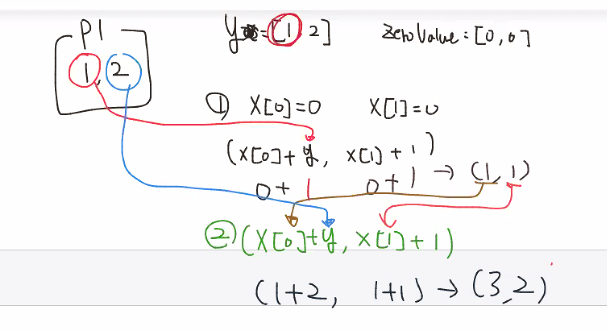

**Partition2 [3,4]**

- x[0]+y = 0+3, x[1]+1 = 0+1 -> (3,1)
- x[0]+y = 3+4 , x[1]+1= 1+1 -> **(7,2)**

**combOp**
- combOp = lambda x, y : (x[0] + y[0], x[1] + y[1])
- p1=(3,2), p2=(7,2)
- x[0]+y[0] = 3+7
- x[1]+y[1] = 2+2 
- **(10,4)**


In [32]:
sc.stop()